<a href="https://colab.research.google.com/github/Ki6an/Machine_Learning_Projects/blob/master/Music%20Gen%20(final)/Music_Gen(upshot)_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# all the data are imported from drive 
import glob
import pickle
import numpy as np
import tensorflow as tf
import tqdm 
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

In [5]:
def get_notes():
    
    """ Extracts all notes and chords from midi files in the ./midi_songs 
    directory and creates a file with all notes in string format"""
    
    notes = []

    for i, file in enumerate(glob.glob("/content/drive/My Drive/Machine Learning /Projects/Music_Gen(upshot)/dataset/*.mid")):
        midi = converter.parse(file)

        # print("Parsing %s" % file)
        print(i,' ',end='')

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    with open('/content/drive/My Drive/Machine Learning /Projects/Music_Gen(upshot)/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

In [6]:
# preaparing the data to feed into the rnn
notes = get_notes()
vocab = sorted(set(item for item in notes))
vocab_size = len(vocab)
notes_to_int = dict((note, number) for number, note in enumerate(vocab))
notes = get_notes()

idx2char = np.array(vocab)

def vectorize_string(notes):
  return np.array([notes_to_int[x] for x in notes])

vectorized_songs = vectorize_string(notes)
len(vectorized_songs), notes[5]

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  210  211  212  213  214  215  216  217  218  219  220  221  

(515757, '5.11')

In [7]:
def get_batch(vectorized_songs, seq_length, batch_size):

  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)


  input_batch = [vectorized_songs[i:i+seq_length] for i in idx]
  output_batch = [vectorized_songs[i+1:i+seq_length+1] for i in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)
x_batch.shape, y_batch.shape

((1, 5), (1, 5))

In [8]:
# building the model
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):

  model = Sequential()

  model.add(Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]))

  model.add(LSTM(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform',
                   recurrent_activation='sigmoid',stateful=True))
  
  model.add(Dense(vocab_size))     

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(vocab_size, embedding_dim=256, rnn_units=1024, batch_size=32)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           123392    
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 482)           494050    
Total params: 5,864,418
Trainable params: 5,864,418
Non-trainable params: 0
_________________________________________________________________


In [9]:

# for plotting 

import time
import matplotlib.pyplot as plt

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

In [19]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 10000  # Increase this to train longer [use 4k]
batch_size = 64                 # Experiment between 1 and 64
seq_length = 100                 # Experiment between 50 and 500
learning_rate = 5e-3            # Experiment between 1e-5 and 1e-1

# Model parameters: 
embedding_dim =  128
rnn_units = 512                # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [20]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate)

def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) 
  return loss

@tf.function
def train_step(x, y): 

  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    y_hat = model(x)
  
    loss = compute_loss(y, y_hat)

  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################


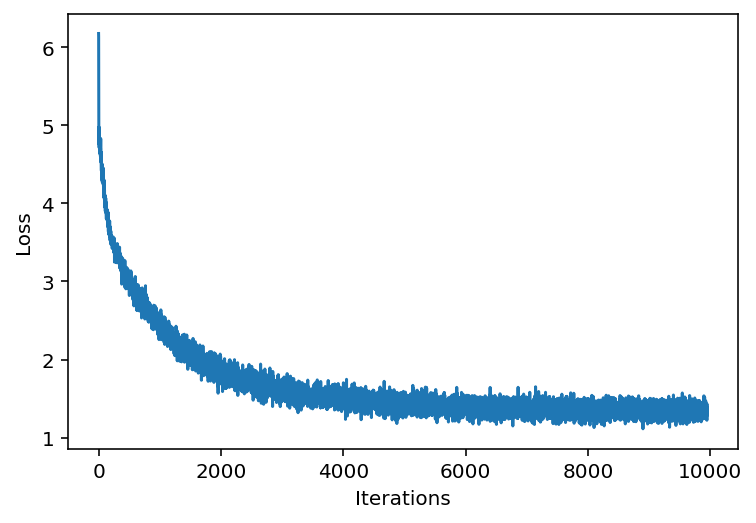

100%|██████████| 10000/10000 [04:45<00:00, 35.06it/s]


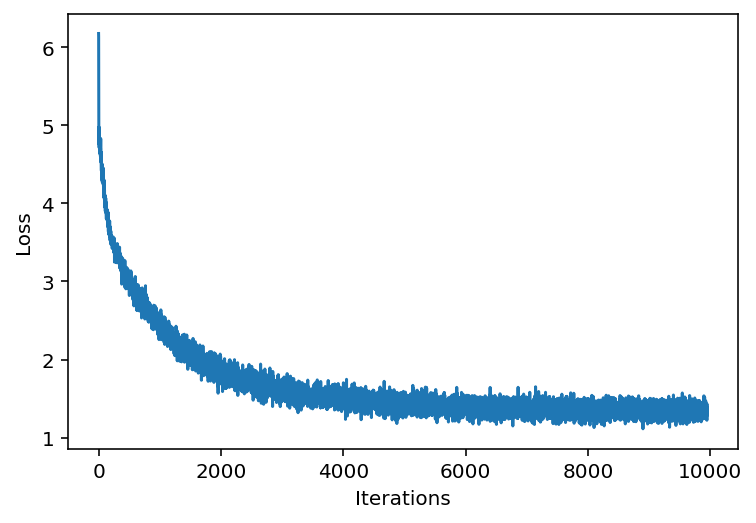

In [21]:
history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)
# model.save('my_model.h5')

In [22]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

# model = tf.keras.models.load_model('my_model.h5')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (1, None, 128)            61696     
_________________________________________________________________
lstm_4 (LSTM)                (1, None, 512)            1312768   
_________________________________________________________________
dense_4 (Dense)              (1, None, 482)            247266    
Total params: 1,621,730
Trainable params: 1,621,730
Non-trainable params: 0
_________________________________________________________________


In [23]:
vectorized_songs[5]

236

In [43]:
def generate_text(model, start_position, generation_length=500):
 
  input_eval = vectorized_songs[start_position:]
 
  input_eval = tf.expand_dims(input_eval, 0)
 
  # Empty string to store our results
  text_generated = [notes[start_position]]
  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()
 
  for i in tqdm(range(generation_length)):
 
      predictions = model(input_eval)
      
      predictions = tf.squeeze(predictions, 0)
 
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
  
      input_eval = tf.expand_dims([predicted_id], 0)

      result = idx2char[predicted_id]
      
      text_generated.append(result)
    #   text_generated.append(',')
    
  return text_generated
      
#       input_eval = tf.expand_dims([predicted_id], 0)
      
#       all_val.append(predicted_id)
 

#   return np.concatenate((vectorized_songs[start_position], all_val), axis=None)

In [44]:
generated_values = generate_text(model, start_position= 8080, generation_length=500)
generated_values[:10],notes[8080]

100%|██████████| 500/500 [00:13<00:00, 37.50it/s]


(['G5', 'F4', 'G4', 'D4', 'D3', 'B-2', 'F5', 'F4', 'G5', 'B-2'], 'G5')

In [45]:
def create_midi(prediction_output):
    
    """ Converts the output from the prediction to notes and create a midi file
        from the notes """
    
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.SnareDrum()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.SnareDrum()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='8080_mel.mid')

    midi_stream.show('midi')

In [46]:
type(generated_values), len(generated_values)

create_midi(generated_values)

# type(predicted_output)